In [77]:
# Import Required Libraries
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [78]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
# Define the DQN Model using PyTorch
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [80]:
# Create Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def size(self):
        return len(self.buffer)

In [84]:
# Define the Training Loop with Performance Tracking
def train_dqn(env, model, target_model, replay_buffer, episodes, batch_size, gamma, epsilon_start, epsilon_min, epsilon_decay, update_target_freq):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    rewards = []  # Initialize rewards as a list
    epsilon = epsilon_start
    
    for e in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Extract the first element if state is a tuple
        state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Ensure state is (1, state_size)
        total_reward = 0
        
        for time in range(500):
            if np.random.rand() <= epsilon:
                action = random.randrange(action_size)
            else:
                with torch.no_grad():
                    action = torch.argmax(model(state)).item()
            
            # Handle the correct number of returned values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done = step_result[:3]
            
            if isinstance(next_state, tuple):
                next_state = next_state[0]  # Extract the first element if next_state is a tuple
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)  # Ensure next_state is (1, state_size)
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            
            if done:
                break
            
            if replay_buffer.size() > batch_size:
                minibatch = replay_buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*minibatch)
                
                states = torch.cat(states).to(device)
                next_states = torch.cat(next_states).to(device)
                actions = torch.tensor(actions).to(device)
                rewards_batch = torch.tensor(rewards_batch).to(device)
                dones = torch.tensor(dones).float().to(device)  # Convert dones to float tensor
                
                # Compute target values
                target = rewards_batch + (1 - dones) * gamma * torch.max(target_model(next_states), dim=1)[0]
                
                # Get current Q values
                current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Compute loss
                loss = criterion(current_q_values, target)
                
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay
        
        rewards.append(total_reward)  # Append total_reward to the list
        
        if e % update_target_freq == 0:
            target_model.load_state_dict(model.state_dict())
        
        # Print episode summary
        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
    
    return rewards

In [85]:
# Hyperparameters
gamma = 0.99
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
episodes = 1000
replay_buffer_size = 10000
update_target_freq = 5

In [86]:
# Initialize environment, model, and replay buffer
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = DQN(state_size, action_size).to(device)
target_model = DQN(state_size, action_size).to(device)
target_model.load_state_dict(model.state_dict())
replay_buffer = ReplayBuffer(max_size=replay_buffer_size)

# Train the model and plot results
rewards = train_dqn(env, model, target_model, replay_buffer, episodes, batch_size, gamma, epsilon_start, epsilon_min, epsilon_decay, update_target_freq)

Episode: 1/1000, Total Reward: 19.0, Epsilon: 0.91
Episode: 2/1000, Total Reward: 15.0, Epsilon: 0.85
Episode: 3/1000, Total Reward: 36.0, Epsilon: 0.71
Episode: 4/1000, Total Reward: 12.0, Epsilon: 0.68
Episode: 5/1000, Total Reward: 13.0, Epsilon: 0.64
Episode: 6/1000, Total Reward: 18.0, Epsilon: 0.58
Episode: 7/1000, Total Reward: 14.0, Epsilon: 0.55
Episode: 8/1000, Total Reward: 11.0, Epsilon: 0.52
Episode: 9/1000, Total Reward: 23.0, Epsilon: 0.47
Episode: 10/1000, Total Reward: 9.0, Epsilon: 0.45
Episode: 11/1000, Total Reward: 14.0, Epsilon: 0.42
Episode: 12/1000, Total Reward: 10.0, Epsilon: 0.40
Episode: 13/1000, Total Reward: 13.0, Epsilon: 0.38
Episode: 14/1000, Total Reward: 11.0, Epsilon: 0.36
Episode: 15/1000, Total Reward: 11.0, Epsilon: 0.34
Episode: 16/1000, Total Reward: 10.0, Epsilon: 0.33
Episode: 17/1000, Total Reward: 11.0, Epsilon: 0.31
Episode: 18/1000, Total Reward: 11.0, Epsilon: 0.30
Episode: 19/1000, Total Reward: 10.0, Epsilon: 0.28
Episode: 20/1000, Tota

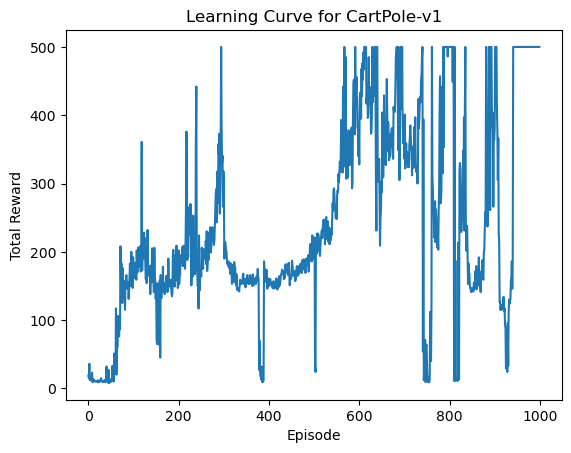

In [87]:
# Plot Learning Curve
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve for CartPole-v1')
plt.show()